In [131]:
import numpy as np 
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

import matplotlib.pyplot as plt 
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
dataset = fetch_20newsgroups()

In [4]:
dataset.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [7]:
dataset['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [108]:
categories = ['soc.religion.christian', 'sci.space','rec.sport.baseball','rec.sport.hockey']

news_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42, download_if_missing=True)

In [109]:
news_data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [110]:
X = news_data['data']

In [111]:
print(len(X))

2389


In [112]:
df = pd.DataFrame({'text':news_data['data'],'category':news_data['target']})
print(df.shape)
df.head()

(2389, 2)


,text,category
0,From: cs89mcd@brunel.ac.uk (Michael C Davis)\n...,3
1,From: mcovingt@aisun3.ai.uga.edu (Michael Covi...,3
2,From: rjungcla@cbnewsd.cb.att.com (R. M. Jungc...,2
3,From: dpage@ra.csc.ti.com (Doug Page)\nSubject...,2
4,From: atterlep@vela.acs.oakland.edu (Cardinal ...,3


In [113]:
news_data['target_names']

['rec.sport.baseball',
 'rec.sport.hockey',
 'sci.space',
 'soc.religion.christian']

In [114]:
df['text'][1]

'From: mcovingt@aisun3.ai.uga.edu (Michael Covington)\nSubject: Re: Pantheism & Environmentalism\nOrganization: AI Programs, University of Georgia, Athens\nLines: 18\n\nIn article <Apr.12.03.44.17.1993.18833@athos.rutgers.edu> heath@athena.cs.uga.edu (Terrance Heath) writes:\n>\n>\tI realize I\'m entering this discussion rather late, but I do\n>have one question. Wasn\'t it a Reagan appointee, James Watt, a\n>pentacostal christian (I think) who was the secretary of the interior\n>who saw no problem with deforestation since we were "living in the\n>last days" and ours would be the last generation to see the redwoods\n>anyway?\n\nI heard the same thing, but without confirmation that he actually said it.\nIt was just as alarming to us as to you; the Bible says that nobody knows\nwhen the second coming will take place.\n\n-- \n:-  Michael A. Covington, Associate Research Scientist        :    *****\n:-  Artificial Intelligence Programs      mcovingt@ai.uga.edu :  *********\n:-  The Univers

## Cleaning text

In [115]:
df['cleaned_text'] = df['text'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x))) if (word.lower() not in stop_words) 
                                                           and word.isalpha() ]))

In [116]:
df.head()

,text,category,cleaned_text
0,From: cs89mcd@brunel.ac.uk (Michael C Davis)\n...,3,brunel ac uk michael c davis subject wbt phone...
1,From: mcovingt@aisun3.ai.uga.edu (Michael Covi...,3,mcovingt ai uga edu michael covington subject ...
2,From: rjungcla@cbnewsd.cb.att.com (R. M. Jungc...,2,rjungcla cbnewsd cb att com r jungclas subject...
3,From: dpage@ra.csc.ti.com (Doug Page)\nSubject...,2,dpage ra csc ti com doug page subject quaint u...
4,From: atterlep@vela.acs.oakland.edu (Cardinal ...,3,atterlep vela ac oakland edu cardinal ximenez ...


## vectorization 

In [117]:
tfidf_model = TfidfVectorizer(max_features=500)
tfidf = tfidf_model.fit_transform(df['cleaned_text']).todense() # to convert it to numpy array

In [118]:
tfidf.shape # this here is the term document matrix

(2389, 500)

# Singular Value Decomposition

In [119]:
svd = TruncatedSVD(n_components=2)
lsa = svd.fit_transform(tfidf) 

In [120]:
lsa.shape # document topic matrix

(2389, 2)

# Topic encoded data

In [121]:
topic_encoded_df = pd.DataFrame(lsa,columns=['topic_1','topic_2'])
topic_encoded_df['category'] = df['category']
topic_encoded_df.head()

,topic_1,topic_2,category
0,0.195504,0.188324,3
1,0.379778,0.136727,3
2,0.242818,0.057285,2
3,0.369480,0.019456,2
4,0.326256,0.289764,3


## The encoding matrix

In [122]:
svd.components_.shape # topic-term matrix

(2, 500)

In [123]:
dictionary = tfidf_model.get_feature_names() # from tfidf model
# these are the features / terms from term-doc matrix

dictionary[:10]

['able',
 'absolute',
 'ac',
 'access',
 'act',
 'actually',
 'adam',
 'address',
 'ago',
 'agree']

In [124]:
encoding_matrix = pd.DataFrame(svd.components_,index = ['topic_1','topic_2']).T
print(encoding_matrix.shape)
encoding_matrix['terms'] = dictionary #adding terms
encoding_matrix.head()

(500, 2)


,topic_1,topic_2,terms
0,0.024570,0.007030,able
1,0.011670,0.038509,absolute
2,0.037131,0.029638,ac
3,0.043620,0.003245,access
4,0.016306,0.037682,act


In [126]:
# getting absolute values 
encoding_matrix['topic_1_abs'] = np.abs(encoding_matrix['topic_1'])
encoding_matrix['topic_2_abs'] = np.abs(encoding_matrix['topic_2'])

encoding_matrix.head()

,topic_1,topic_2,terms,topic_1_abs,topic_2_abs
0,0.024570,0.007030,able,0.024570,0.007030
1,0.011670,0.038509,absolute,0.011670,0.038509
2,0.037131,0.029638,ac,0.037131,0.029638
3,0.043620,0.003245,access,0.043620,0.003245
4,0.016306,0.037682,act,0.016306,0.037682


In [127]:
# top words in topic 1 
encoding_matrix.sort_values(by='topic_1_abs',ascending=False)['terms'][:5]

122      edu
87       com
491    would
158     game
495     year
Name: terms, dtype: object

In [128]:
# top words in topic 2
encoding_matrix.sort_values(by='topic_2_abs',ascending=False)['terms'][:5]

168          god
77     christian
158         game
442         team
211        jesus
Name: terms, dtype: object

## importance of topic 

In [129]:
svd.singular_values_

array([14.26357613,  7.70354267])

## Visuslization of topics

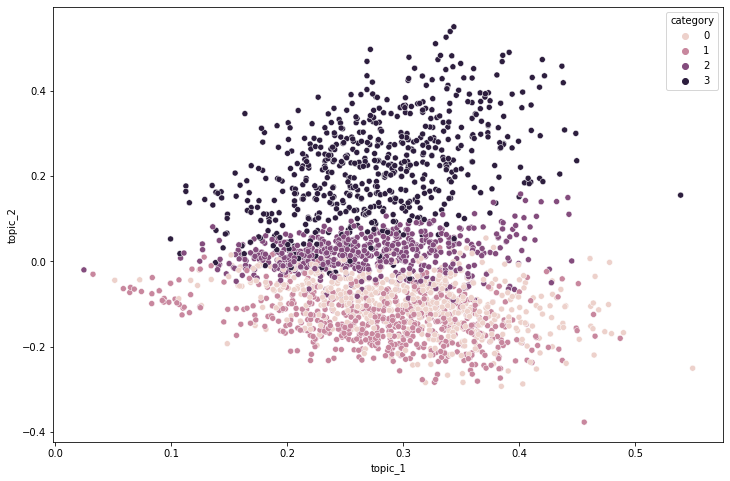

In [134]:
plt.figure(figsize=[12,8])
sns.scatterplot(x='topic_1',y='topic_2',hue='category',data = topic_encoded_df)

# Chossing greater number of topics 

# Singular Value Decomposition

In [135]:
svd = TruncatedSVD(n_components=4)
lsa = svd.fit_transform(tfidf) 

In [136]:
lsa.shape # document topic matrix

(2389, 4)

# Topic encoded data

In [137]:
topic_encoded_df = pd.DataFrame(lsa,columns=['topic_1','topic_2','topic_3','topic_4'])
topic_encoded_df['category'] = df['category']
topic_encoded_df.head()

,topic_1,topic_2,topic_3,topic_4,category
0,0.195504,0.188537,-0.050598,-0.002261,3
1,0.379778,0.136755,0.008240,0.199573,3
2,0.242818,0.057200,0.112555,-0.104733,2
3,0.369479,0.019052,0.103561,0.004855,2
4,0.326256,0.289830,-0.090990,-0.019715,3


## The encoding matrix

In [138]:
svd.components_.shape # topic-term matrix

(4, 500)

In [139]:
dictionary = tfidf_model.get_feature_names() # from tfidf model
# these are the features / terms from term-doc matrix

dictionary[:10]

['able',
 'absolute',
 'ac',
 'access',
 'act',
 'actually',
 'adam',
 'address',
 'ago',
 'agree']

In [140]:
encoding_matrix = pd.DataFrame(svd.components_,index = ['topic_1','topic_2','topic_3','topic_4']).T
print(encoding_matrix.shape)
encoding_matrix['terms'] = dictionary #adding terms
encoding_matrix.head()

(500, 4)


,topic_1,topic_2,topic_3,topic_4,terms
0,0.024570,0.007044,-0.003235,-0.002757,able
1,0.011670,0.038496,-0.019952,-0.005632,absolute
2,0.037131,0.029689,-0.008851,0.022243,ac
3,0.043620,0.003148,0.155911,-0.097556,access
4,0.016306,0.037688,-0.009204,-0.003206,act


In [141]:
# getting absolute values 
encoding_matrix['topic_1_abs'] = np.abs(encoding_matrix['topic_1'])
encoding_matrix['topic_2_abs'] = np.abs(encoding_matrix['topic_2'])
encoding_matrix['topic_3_abs'] = np.abs(encoding_matrix['topic_3'])
encoding_matrix['topic_4_abs'] = np.abs(encoding_matrix['topic_4'])

encoding_matrix.head()

,topic_1,topic_2,topic_3,topic_4,terms,topic_1_abs,topic_2_abs,topic_3_abs,topic_4_abs
0,0.024570,0.007044,-0.003235,-0.002757,able,0.024570,0.007044,0.003235,0.002757
1,0.011670,0.038496,-0.019952,-0.005632,absolute,0.011670,0.038496,0.019952,0.005632
2,0.037131,0.029689,-0.008851,0.022243,ac,0.037131,0.029689,0.008851,0.022243
3,0.043620,0.003148,0.155911,-0.097556,access,0.043620,0.003148,0.155911,0.097556
4,0.016306,0.037688,-0.009204,-0.003206,act,0.016306,0.037688,0.009204,0.003206


In [142]:
# top words in topic 1 
encoding_matrix.sort_values(by='topic_1_abs',ascending=False)['terms'][:5]

122      edu
87       com
491    would
158     game
495     year
Name: terms, dtype: object

In [143]:
# top words in topic 2
encoding_matrix.sort_values(by='topic_2_abs',ascending=False)['terms'][:5]

168          god
77     christian
158         game
442         team
211        jesus
Name: terms, dtype: object

In [144]:
# top words in topic 3
encoding_matrix.sort_values(by='topic_3_abs',ascending=False)['terms'][:5]

419    space
284     nasa
172      gov
168      god
158     game
Name: terms, dtype: object

In [145]:
# top words in topic 4
encoding_matrix.sort_values(by='topic_4_abs',ascending=False)['terms'][:5]

122           edu
442          team
59             ca
284          nasa
468    university
Name: terms, dtype: object

Note: - there is no change in the terms associated with topic 1 and topic 2.
<br>
Even if we add more topcis, the earlier topcis structure will remain the same.

## importance of topic 

In [146]:
svd.singular_values_

array([14.26357613,  7.70354139,  6.99998081,  6.00097808])